In [1]:
from photonflux.circuit import PhotonicCircuit
from photonflux.component_models.default_model_dict import models_dict
import numpy as np
import networkx as nx
import gdsfactory as gf
import matplotlib.pyplot as plt

2023-02-23 23:01:51.730 | INFO     | gdsfactory.config:<module>:51 - Load 'c:\\anaconda\\lib\\site-packages\\gdsfactory' 6.41.0
2023-02-23 23:01:51.771 | INFO     | gdsfactory.technology.layer_views:__init__:779 - Importing LayerViews from KLayout layer properties file: c:\anaconda\lib\site-packages\gdsfactory\generic_tech\klayout\tech\layers.lyp.


You need install jupyter notebook plugin with `pip install gdsfactory[full]`
You can install `pip install gdsfactory[full]` for better visualization


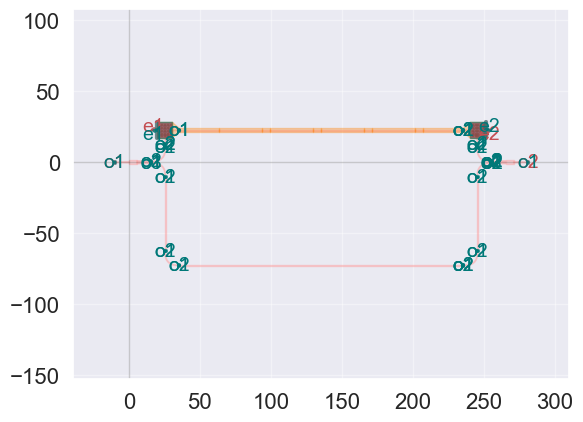

In [2]:
delta_length = 100

mzi_component = gf.components.mzi_phase_shifter(
    delta_length=delta_length,
    straight_x_top=gf.components.straight_heater_metal,
)

mzi_netlist_for_test = mzi_component.get_netlist()

mzi_component

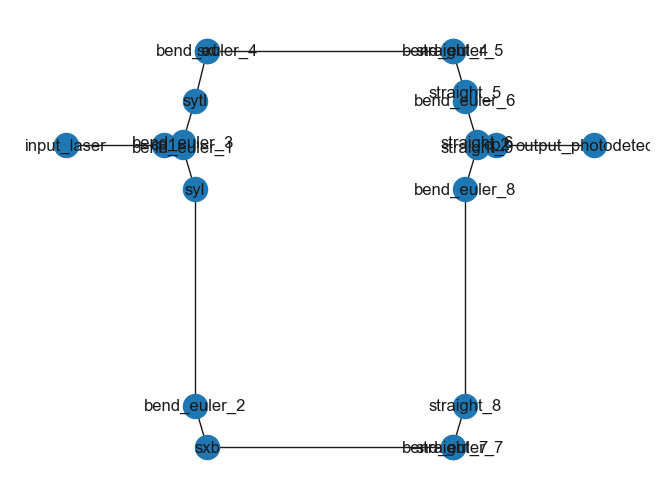

In [3]:
mzi_circuit = PhotonicCircuit(mzi_netlist_for_test, models_dict)

input_port = mzi_circuit.ports[0]
output_port = mzi_circuit.ports[1]

mzi_circuit.add_laser_port(input_port, mzi_circuit.positions)
mzi_circuit.add_photodetector_port(output_port, mzi_circuit.positions)

pos = {k: (v["x"], v["y"]) for k, v in mzi_circuit.positions.items()}

nx.draw(
    mzi_circuit.graph,
    with_labels=True,
    font_weight=8,
    pos=pos,
)

In [4]:
undercut_mzi_component = gf.components.mzi_phase_shifter(
    delta_length=delta_length,
    straight_x_top=gf.components.straight_heater_metal_undercut,
)

mzi_undercutcircuit = PhotonicCircuit(undercut_mzi_component.get_netlist(), models_dict)

input_port = mzi_undercutcircuit.ports[0]
output_port = mzi_undercutcircuit.ports[1]

mzi_undercutcircuit.add_laser_port(input_port, mzi_undercutcircuit.positions)
mzi_undercutcircuit.add_photodetector_port(output_port, mzi_undercutcircuit.positions)

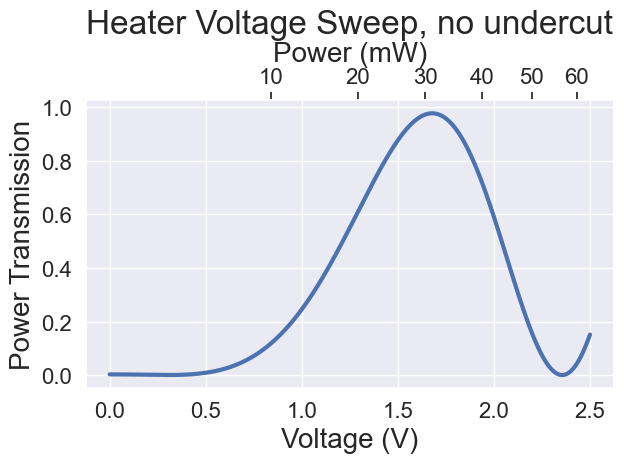

Text(0.5, 1.0, 'Heater Voltage Sweep, undercut')

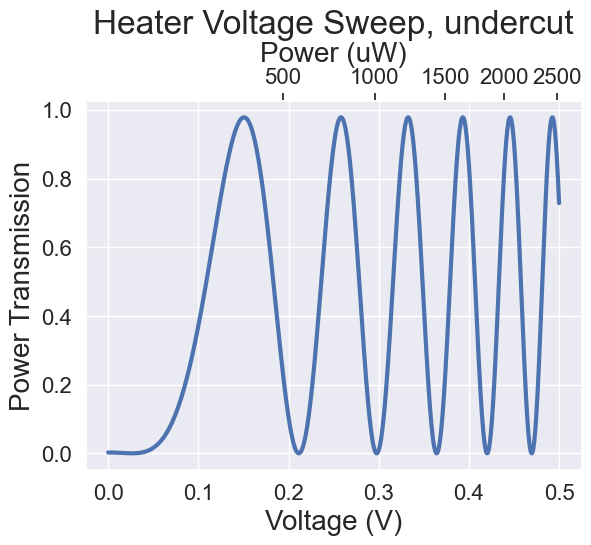

In [5]:
heater_comp_refs = mzi_circuit.return_components_callback(["sxt","sxb"])
undercut_heater_comp_refs = mzi_undercutcircuit.return_components_callback(['sxt','sxb'])
heater_ref = heater_comp_refs[0]
undercut_heater_ref = undercut_heater_comp_refs[0]
voltage_sweep = np.linspace(0,2.5,num=1000)
storage = []

for v in voltage_sweep:
    heater_ref.update_voltage(v)
    mzi_circuit.update_all_edges()
    detector_value = mzi_circuit.readout_from_photodetectors()
    storage.append(detector_value[0])

heater_ref.update_voltage(0)




plt.figure()
def volt2pwr(x):
    return x**2/heater_ref.resistance*1e3

def pwr2volt(x):
    return np.sqrt(x * heater_ref.resistance)/1e3
ax = plt.gca()
ax.plot(voltage_sweep,storage)
secax = ax.secondary_xaxis('top', functions=(volt2pwr, pwr2volt))
secax.set_xlabel('Power (mW)')

plt.xlabel("Voltage (V)")
plt.ylabel("Power Transmission")
plt.title("Heater Voltage Sweep, no undercut")
plt.tight_layout()
plt.show()

undercut_storage = []
voltage_sweep = np.linspace(0,0.5,num=1000)
for v in voltage_sweep:
    undercut_heater_ref.update_voltage(v)
    mzi_undercutcircuit.update_all_edges()
    detector_value = mzi_undercutcircuit.readout_from_photodetectors()
    undercut_storage.append(detector_value[0])

undercut_heater_ref.update_voltage(0)
plt.figure()
def volt2pwr(x):
    return x**2/heater_ref.resistance*1e6

def pwr2volt(x):
    return np.sqrt(x * heater_ref.resistance)/1e6
ax = plt.gca()
ax.plot(voltage_sweep,undercut_storage)
secax = ax.secondary_xaxis('top', functions=(volt2pwr, pwr2volt))
secax.set_xlabel('Power (uW)')
plt.xlabel("Voltage (V)")
plt.ylabel("Power Transmission")
plt.title("Heater Voltage Sweep, undercut")

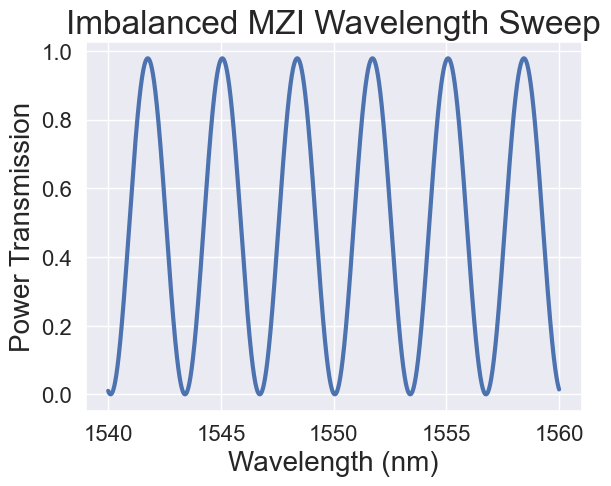

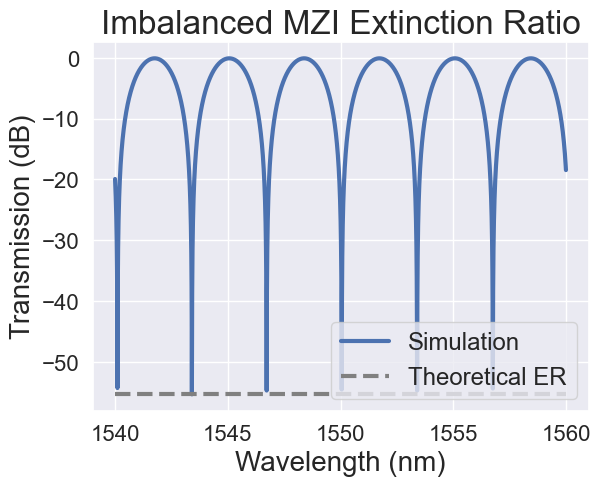

In [6]:
# Wavelength sweep
wavelength_sweep = np.linspace(1.54e-6,1.56e-6,num=10000)
storage = []
for wl in wavelength_sweep:
    mzi_circuit.update_wavelength(wl)
    mzi_circuit.update_all_edges()
    detector_value = mzi_circuit.readout_from_photodetectors()
    storage.append(detector_value[0])

mzi_circuit.update_wavelength(1.55e-6)

plt.figure()
plt.plot(wavelength_sweep*1e9,storage)
plt.xlabel("Wavelength (nm)")
plt.ylabel("Power Transmission")
plt.title("Imbalanced MZI Wavelength Sweep")
plt.show()

#What is the extinction ratio of the MZI?
#We are assuming alpha=3dB/cm so calculate that analytically

alpha_m = 300/4.34
delta_length_m = delta_length*1e-6
num = (1 + np.exp(-alpha_m*delta_length_m/2))**2
denom = (1 - np.exp(-alpha_m*delta_length_m/2))**2
ER = num/denom
ER_dB = 10*np.log10(ER)

plt.figure()
plt.plot(wavelength_sweep*1e9,10*np.log10(storage))
plt.hlines(y=-ER_dB,xmin=np.min(wavelength_sweep)*1e9,xmax=np.max(wavelength_sweep)*1e9,color='grey',linestyles='--')
plt.legend(['Simulation','Theoretical ER'])
plt.xlabel("Wavelength (nm)")
plt.ylabel("Transmission (dB)")
plt.title("Imbalanced MZI Extinction Ratio")
plt.show()